In [2]:
import copy
import glob
import regex as re
import numpy as np
import pandas as pd
import datetime as dt
import xgboost as xgb
import tensorflow as tf
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.2f}'.format
%matplotlib inline
%load_ext rpy2.ipython
%run ../airquality/data/gen_daily_targets.py
%run ../airquality/data/prepare_data.py

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
test = pd.read_csv('../data/targets.csv')
stations = pd.read_csv('../data/stations.csv')

In [66]:
observations = pd.read_csv('../data/observations.csv', index_col=0)
models = pd.read_csv('../data/models.csv', index_col=0)
obs_and_mods = pd.merge(models, observations, how='left',
                    on=['station', 'day', 'time', 'datetime' ,'year'],
                    suffixes=('_mod', '')).sort_values('datetime', ascending=True)
obs_and_mods.to_csv('../data/obs_and_mod.csv')
obs_and_mods_cols = ['pred_0_days', 'pred_1_days', 'Concentration', 'target', 'day']
obs_and_mods.head()

,pred_0_days,pred_1_days,day,lon,lat,year,station,datetime,time,Concentration,target
0,38.79,34.11,2013-01-01,2.15,41.39,2013,ES1438A,2013-01-01 00:00:00,00:00:00,nan,nan
1,28.53,27.48,2013-01-01,2.13,41.38,2013,ES1396A,2013-01-01 00:00:00,00:00:00,nan,nan
2,35.85,42.57,2013-01-01,2.20,41.40,2013,ES0691A,2013-01-01 00:00:00,00:00:00,nan,nan
3,31.81,31.59,2013-01-01,2.15,41.40,2013,ES1480A,2013-01-01 00:00:00,00:00:00,nan,nan
4,31.81,31.59,2013-01-01,2.15,41.43,2013,ES1856A,2013-01-01 00:00:00,00:00:00,nan,nan


In [80]:
agg_types = ['max']
tall_series = obs_and_mods.fillna(0).groupby(['day', 'station']).agg({
    'Concentration': agg_types
})['Concentration'].reset_index()
aggs = [tall_series.pivot(index='day', columns='station', values=agg) for agg in agg_types]
aggs = [df.rename(columns={c: c + '_' + agg for c in df.columns}) for df, agg in zip(aggs, agg_types)]
wide_series = pd.concat(aggs, axis=1)

In [81]:
tall_series_mod = obs_and_mods.fillna(0).groupby(['day', 'station']).agg({
    'pred_0_days': agg_types
})['pred_0_days'].reset_index().rename(columns={
    'pred_0_days': 'Concentration'
})
wide_series_mod = tall_series_mod\
    .pivot(index='day', columns='station', values='max')\
    .rename(columns={c: c + '_max' for c in tall_series_mod.columns})
wide_series_mod.tail()

station,ES0691A,ES1396A,ES1438A,ES1480A,ES1679A,ES1856A,ES1992A
day,,,,,,,
2015-12-27,104.21,96.41,104.76,108.53,104.76,108.53,96.41
2015-12-28,123.89,116.91,135.50,131.59,135.50,131.59,116.91
2015-12-29,93.35,113.39,106.20,113.48,106.20,113.48,113.39
2015-12-30,103.20,91.71,95.34,105.85,95.34,105.85,91.71
2015-12-31,103.42,97.83,109.93,107.90,109.93,107.90,97.83


In [82]:
to_impute = wide_series.loc[test['date'].unique()]
for s in obs_and_mods.station.unique():
    to_impute[s + '_max'] = wide_series_mod.loc[to_impute.reset_index().day, s]
originals = wide_series[list(~wide_series.reset_index().day.isin(test['date'].unique()))]
wide_series_imputed = pd.concat([to_impute, originals]).sort_index()
wide_series_imputed.head()

station,ES0691A_max,ES1396A_max,ES1438A_max,ES1480A_max,ES1679A_max,ES1856A_max,ES1992A_max
day,,,,,,,
2013-01-01,72.00,98.00,112.00,94.00,69.00,39.00,68.00
2013-01-02,87.00,86.00,119.00,79.00,76.00,77.00,85.00
2013-01-03,119.00,85.00,117.00,102.00,78.00,94.00,110.00
2013-01-04,80.00,113.00,123.00,187.00,108.00,60.00,99.00
2013-01-05,60.00,114.00,0.00,131.00,114.00,16.00,85.00


In [93]:
X.shape

(733, 600)

In [95]:
len(list(~wide_series.reset_index()['day'].isin(test['date'].unique()))[:X.shape[0]])

733

In [100]:
%%time
lags = 100
preds_by_station = []
edit_wide_series = copy.deepcopy(wide_series)
for d in test['date'].unique():
    data = wide_series_imputed[list(pd.to_datetime(wide_series_imputed.reset_index().day) <= d)]
    for s in test['station'].unique():
        to_lag = data[[c for c in data.columns if not c in ['{}_{}'.format(s, agg) for agg in agg_types]]]
        X = create_lagged_features(to_lag, lags)
        X_train = np.nan_to_num(X.loc[
            list(~wide_series.reset_index()['day'].isin(test['date'].unique()))[:X.shape[0]]
        ])
        for agg in agg_types:
            print('Predicting {} for station {} day {}'.format(agg, s, d))
            y_train = np.nan_to_num(data.loc[
                list(~wide_series.reset_index()['day'].isin(test['date'].unique()))[:X.shape[0]],
                '{}_{}'.format(s, agg)
            ])
            X_test = np.nan_to_num(X.iloc[-1].values.reshape(1, X.shape[1]))
            model = xgb.XGBRegressor(n_estimators=100, n_jobs=4)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            edit_wide_series.loc[d, '{}_{}'.format(s, agg)] = y_pred
            print(y_pred)

Predicting max for station ES0691A day 2015-01-03
[ 68.57057953]
Predicting max for station ES1396A day 2015-01-03
[ 74.51229858]
Predicting max for station ES1438A day 2015-01-03
[ 103.8181076]
Predicting max for station ES1480A day 2015-01-03
[ 99.81520081]
Predicting max for station ES1679A day 2015-01-03
[ 78.67909241]
Predicting max for station ES1856A day 2015-01-03
[ 67.66657257]
Predicting max for station ES1992A day 2015-01-03
[ 79.93198395]
Predicting max for station ES0691A day 2015-01-06
[ 79.28159332]
Predicting max for station ES1396A day 2015-01-06
[ 68.53066254]
Predicting max for station ES1438A day 2015-01-06
[ 103.03289032]
Predicting max for station ES1480A day 2015-01-06
[ 103.84335327]
Predicting max for station ES1679A day 2015-01-06
[ 78.23953247]
Predicting max for station ES1856A day 2015-01-06
[ 80.5218277]
Predicting max for station ES1992A day 2015-01-06
[ 75.51863861]
Predicting max for station ES0691A day 2015-01-09
[ 80.13047028]
Predicting max for stati

[ 65.36904907]
Predicting max for station ES1396A day 2015-02-26
[ 75.92066956]
Predicting max for station ES1438A day 2015-02-26
[ 95.751091]
Predicting max for station ES1480A day 2015-02-26
[ 109.22027588]
Predicting max for station ES1679A day 2015-02-26
[ 78.30376434]
Predicting max for station ES1856A day 2015-02-26
[ 77.37188721]
Predicting max for station ES1992A day 2015-02-26
[ 80.68737793]
Predicting max for station ES0691A day 2015-03-01
[ 59.31064606]
Predicting max for station ES1396A day 2015-03-01
[ 67.60121155]
Predicting max for station ES1438A day 2015-03-01
[ 77.524086]
Predicting max for station ES1480A day 2015-03-01
[ 87.68830109]
Predicting max for station ES1679A day 2015-03-01
[ 62.56375504]
Predicting max for station ES1856A day 2015-03-01
[ 44.59351349]
Predicting max for station ES1992A day 2015-03-01
[ 57.86063385]
Predicting max for station ES0691A day 2015-03-04
[ 70.07691956]
Predicting max for station ES1396A day 2015-03-04
[ 73.42673492]
Predicting ma

[ 80.59088135]
Predicting max for station ES1396A day 2015-04-21
[ 75.61054993]
Predicting max for station ES1438A day 2015-04-21
[ 102.15405273]
Predicting max for station ES1480A day 2015-04-21
[ 92.24357605]
Predicting max for station ES1679A day 2015-04-21
[ 71.1835556]
Predicting max for station ES1856A day 2015-04-21
[ 72.14630127]
Predicting max for station ES1992A day 2015-04-21
[ 71.20605469]
Predicting max for station ES0691A day 2015-04-24
[ 70.98590088]
Predicting max for station ES1396A day 2015-04-24
[ 77.15369415]
Predicting max for station ES1438A day 2015-04-24
[ 94.06192017]
Predicting max for station ES1480A day 2015-04-24
[ 97.54772949]
Predicting max for station ES1679A day 2015-04-24
[ 75.39357758]
Predicting max for station ES1856A day 2015-04-24
[ 74.59381866]
Predicting max for station ES1992A day 2015-04-24
[ 96.04203033]
Predicting max for station ES0691A day 2015-04-27
[ 70.4665451]
Predicting max for station ES1396A day 2015-04-27
[ 64.17601013]
Predicting 

[ 43.76751709]
Predicting max for station ES1438A day 2015-06-14
[ 87.01737213]
Predicting max for station ES1480A day 2015-06-14
[ 65.46187592]
Predicting max for station ES1679A day 2015-06-14
[ 65.56188202]
Predicting max for station ES1856A day 2015-06-14
[ 44.25463104]
Predicting max for station ES1992A day 2015-06-14
[ 44.45840836]
Predicting max for station ES0691A day 2015-06-17
[ 58.25794601]
Predicting max for station ES1396A day 2015-06-17
[ 55.01948166]
Predicting max for station ES1438A day 2015-06-17
[ 84.41111755]
Predicting max for station ES1480A day 2015-06-17
[ 82.79142761]
Predicting max for station ES1679A day 2015-06-17
[ 46.07874298]
Predicting max for station ES1856A day 2015-06-17
[ 59.08313751]
Predicting max for station ES1992A day 2015-06-17
[ 79.6713562]
Predicting max for station ES0691A day 2015-06-20
[ 62.34834671]
Predicting max for station ES1396A day 2015-06-20
[ 61.47211838]
Predicting max for station ES1438A day 2015-06-20
[ 85.76670074]
Predicting 

Predicting max for station ES1438A day 2015-08-07
[ 81.04393768]
Predicting max for station ES1480A day 2015-08-07
[ 74.85408783]
Predicting max for station ES1679A day 2015-08-07
[ 70.90099335]
Predicting max for station ES1856A day 2015-08-07
[ 76.18994904]
Predicting max for station ES1992A day 2015-08-07
[ 71.72337341]
Predicting max for station ES0691A day 2015-08-10
[ 58.52804565]
Predicting max for station ES1396A day 2015-08-10
[ 51.35611343]
Predicting max for station ES1438A day 2015-08-10
[ 88.2537384]
Predicting max for station ES1480A day 2015-08-10
[ 69.55666351]
Predicting max for station ES1679A day 2015-08-10
[ 57.75811005]
Predicting max for station ES1856A day 2015-08-10
[ 52.39949036]
Predicting max for station ES1992A day 2015-08-10
[ 69.17878723]
Predicting max for station ES0691A day 2015-08-13
[ 67.00850677]
Predicting max for station ES1396A day 2015-08-13
[ 57.70851898]
Predicting max for station ES1438A day 2015-08-13
[ 76.05795288]
Predicting max for station

[ 81.46878815]
Predicting max for station ES1480A day 2015-09-30
[ 94.39445496]
Predicting max for station ES1679A day 2015-09-30
[ 63.84395599]
Predicting max for station ES1856A day 2015-09-30
[ 61.85630035]
Predicting max for station ES1992A day 2015-09-30
[ 75.23530579]
Predicting max for station ES0691A day 2015-10-03
[ 72.13962555]
Predicting max for station ES1396A day 2015-10-03
[ 62.49078751]
Predicting max for station ES1438A day 2015-10-03
[ 79.78369141]
Predicting max for station ES1480A day 2015-10-03
[ 93.95372772]
Predicting max for station ES1679A day 2015-10-03
[ 68.7053833]
Predicting max for station ES1856A day 2015-10-03
[ 69.33441925]
Predicting max for station ES1992A day 2015-10-03
[ 76.9696579]
Predicting max for station ES0691A day 2015-10-06
[ 85.80866241]
Predicting max for station ES1396A day 2015-10-06
[ 75.59172058]
Predicting max for station ES1438A day 2015-10-06
[ 92.74299622]
Predicting max for station ES1480A day 2015-10-06
[ 86.56925964]
Predicting m

[ 97.76221466]
Predicting max for station ES1679A day 2015-11-23
[ 73.77328491]
Predicting max for station ES1856A day 2015-11-23
[ 62.37839127]
Predicting max for station ES1992A day 2015-11-23
[ 78.11631775]
Predicting max for station ES0691A day 2015-11-26
[ 76.89772797]
Predicting max for station ES1396A day 2015-11-26
[ 87.77414703]
Predicting max for station ES1438A day 2015-11-26
[ 109.70736694]
Predicting max for station ES1480A day 2015-11-26
[ 111.37075806]
Predicting max for station ES1679A day 2015-11-26
[ 79.40436554]
Predicting max for station ES1856A day 2015-11-26
[ 86.81246185]
Predicting max for station ES1992A day 2015-11-26
[ 75.64936066]
Predicting max for station ES0691A day 2015-11-29
[ 68.59558868]
Predicting max for station ES1396A day 2015-11-29
[ 73.37419128]
Predicting max for station ES1438A day 2015-11-29
[ 95.36408997]
Predicting max for station ES1480A day 2015-11-29
[ 78.30778503]
Predicting max for station ES1679A day 2015-11-29
[ 75.58973694]
Predicti

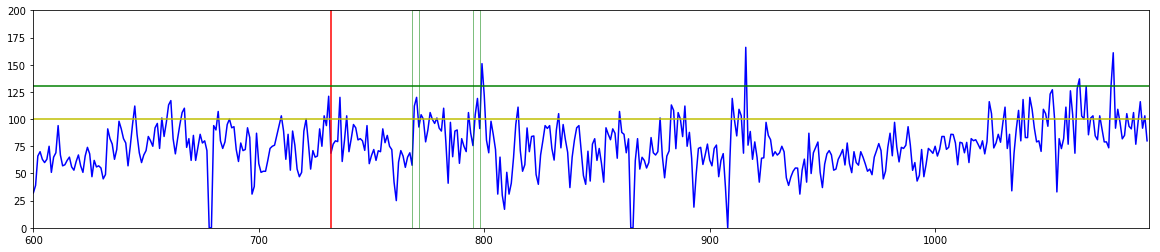

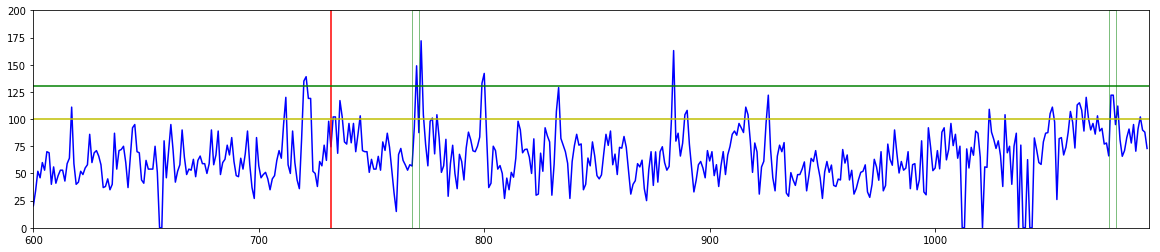

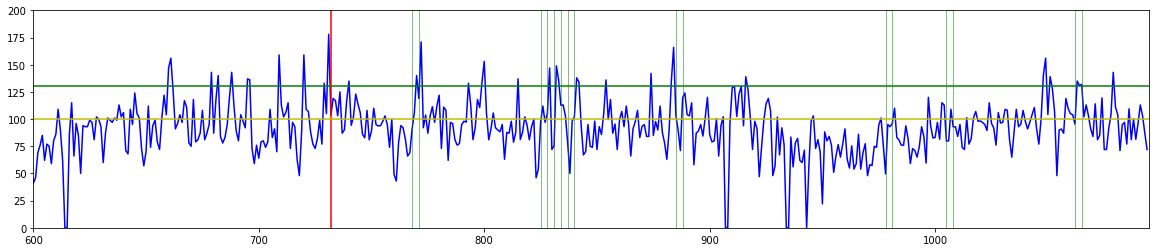

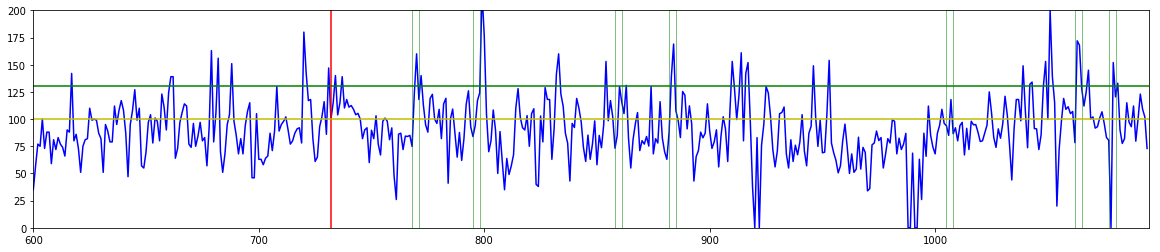

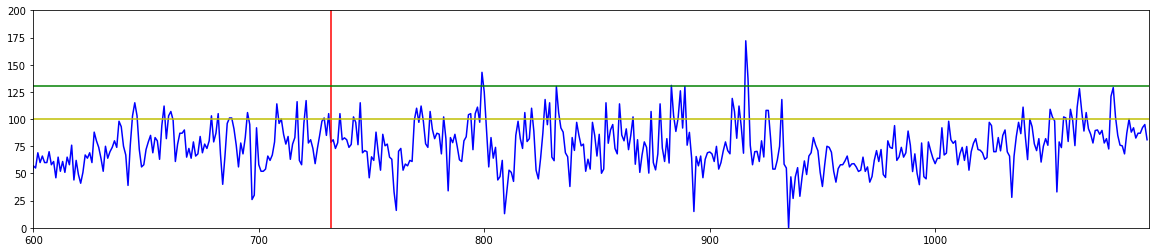

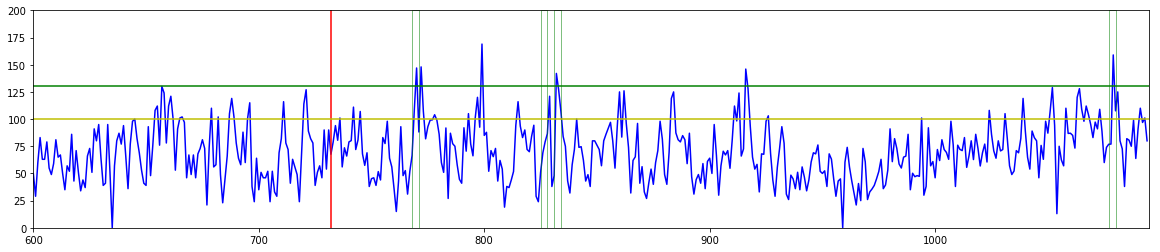

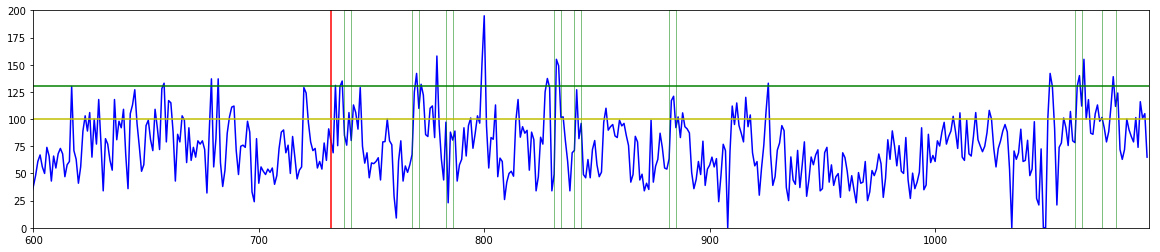

In [101]:
for c in edit_wide_series.columns:
    if '_max' in c:
        plt.figure(figsize=(20, 4))
        x_ax = list(range(edit_wide_series.shape[0]))
        plt.plot(x_ax, edit_wide_series[c], 'b-')
        plt.step((pd.to_datetime(test[test.station == c[:7]].date) - dt.datetime(2013, 1, 1)).map(lambda d: d.days),
                 test.loc[test.station == c[:7], 'target'] * 200, 'g--', lw=.5)
        plt.xlim([600, edit_wide_series.shape[0]])
        plt.ylim([0, 200])
        plt.axvline(732, c='r')
        plt.axhline(100, c='y')
        plt.axhline(130, c='g')

In [108]:
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, precision_score, recall_score, mean_squared_error

lags = 10
kf = KFold(n_splits=3)
metric_by_station = []
for s in obs_and_mods.station.unique():
    data = wide_series[list(wide_series.reset_index().day < '2015-01-01')]
    to_lag = data[[c for c in data.columns if not c in ['{}_{}'.format(s, agg) for agg in agg_types]]]
    features = pd.concat([
        create_lagged_features(to_lag, lags),
        obs_and_mods[obs_and_mods.station == s].groupby('day').max()
    ], axis=1).dropna()
    X = features[[c for c in features.columns if not c in [
        'time', 'datetime', 'Concentration', 'target', 'station'
    ]]].values
    y = features['Concentration'].values
    metric = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = xgb.XGBRegressor(n_estimators=100)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        metric.append(
            mean_squared_error(y_test, y_pred)
        ) 
        
    metric_by_station.append((s, np.mean(metric)))
    
metric_by_station

[('ES1438A', 634.65030524237397),
 ('ES1396A', 549.77879977684972),
 ('ES0691A', 357.55035029793856),
 ('ES1480A', 578.72624419840201),
 ('ES1856A', 547.69752227398919),
 ('ES1679A', 379.74367886383203),
 ('ES1992A', 662.35596367399455)]

In [109]:
np.mean([e[1] for e in metric_by_station])

530.07183776105433